In [1]:
import os
import pandas as pd
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from hydroDL.post import mapplot, axplot, figplot
import numpy as np
from hydroDL import kPath

loading package hydroDL


In [2]:

DIR_VEG = os.path.join(kPath.dirVeg,'data')

# load LFMC
fileLFMC = os.path.join(DIR_VEG, 'LFMC-global.csv')
tabLFMC = pd.read_csv(fileLFMC)

# date > 2015
tabData = tabLFMC
tabData = tabLFMC[tabLFMC['Sampling date'] > 20150101]
tabLFMC['Sampling date'].max()


# add site id
temp = tabData['ID'].str.split('_', 2, expand=True)
siteId = temp[0].str.cat(temp[1], sep='_')
siteIdLst = siteId.unique().tolist()
tabData['siteId'] = siteId

# add spec id
fileSpec = os.path.join(DIR_VEG, 'spec-fix')
dfFix = pd.read_csv(fileSpec, index_col=0)
tab = tabData.merge(dfFix, left_on='Species collected', right_index=True)
tab[tab['Sitename'] == 'Shoshone Basin']
len(tab)


# with open('temp', 'w') as fp:
#     for item in sorted(tab['try_id'].unique().tolist()):
#         fp.write('{}, '.format(item))


# load DMC
fileDMC = os.path.join(DIR_VEG, 'TRY', 'DMC.csv')
tabDMC_temp = pd.read_csv(fileDMC)
meanDMC = tabDMC_temp.groupby(['AccSpeciesID'])['StdValue'].mean()
medianDMC = tabDMC_temp.groupby(['AccSpeciesID'])['StdValue'].median()
stdDMC = tabDMC_temp.groupby(['AccSpeciesID'])['StdValue'].std()
meanDMC = meanDMC.rename('DMC')
stdDMC = stdDMC.rename('DMC_std')
tabDMC = pd.merge(meanDMC, stdDMC, right_index=True, left_index=True)
tab = tab.merge(tabDMC, left_on='try_id', right_on='AccSpeciesID')
tab['LFMC'] = tab['LFMC value'] / 100
tab['date'] = pd.to_datetime(tab['Sampling date'], format='%Y%m%d')
tab['RWC'] = tab['DMC'] * tab['LFMC'] / (1 - tab['DMC'])
tab.to_csv(os.path.join(DIR_VEG, 'rwc.csv'), index=False)


# extract sites
tabPlot = tab[['siteId', 'date', 'try_id', 'try_spec', 'LFMC', 'RWC', 'DMC']]
tabSite = tab[
    ['siteId', 'Sitename', 'State/Region', 'Latitude', 'Longitude']
].drop_duplicates()
cntSample = tabPlot.groupby(['siteId'])['try_id'].count().reset_index('siteId')
tabSite = tabSite.merge(cntSample, left_on='siteId', right_on='siteId')
# save sites
tabS = tabSite[['siteId', 'Latitude', 'Longitude']]
tabS.to_csv(os.path.join(DIR_VEG, 'rwc_sites.csv'), index=False)

/home/users/kuaifang/envs/pytorch/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3442: DtypeWarning: Columns (7,20,22) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/tmp/ipykernel_28401/772840996.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tabData['siteId'] = siteId


In [3]:

# plot ts map
lat = tabSite['Latitude'].values
lon = tabSite['Longitude'].values
extentUS = [-125, -65, 25, 50]
extentEU = [-5, 15, 40, 45]
extentGlobal = [-180, 180, -90, 90]


def funcM():
    figM = plt.figure(figsize=(8, 6))
    gsM = gridspec.GridSpec(1, 1)
    axM = mapplot.mapPoint(
        figM, gsM[0, 0], lat, lon, tabSite['try_id'], extent=extentGlobal
    )
    figP, axP = plt.subplots(2, 1)
    return figM, axM, figP, axP, lon, lat


def funcP(iP, axP):
    print(iP)
    siteId = tabSite.iloc[iP]['siteId']
    tabData = tabPlot[tabPlot['siteId'] == siteId]
    specLst = tabData['try_spec'].unique().tolist()
    for spec in specLst:
        temp = tabData[tabData['try_spec'] == spec]
        axP[0].plot(temp['date'], temp['LFMC'], '-*', label=spec)
        axP[1].plot(
            temp['date'], temp['RWC'], '-*', label='{:.2f}'.format(temp.iloc[0]['DMC'])
        )
    axP[0].legend()
    axP[1].legend()


In [4]:
def onclick(event, figP, axP):
    xClick = event.xdata
    yClick = event.ydata
    if xClick is None or yClick is None:
        print('click on map plz')
        return
    iP = findPoint(xClick, yClick, xLoc, yLoc)
    print(iP)
    for ax in axM.flatten():
        [p.remove() for p in reversed(ax.patches)]
        xc = xLoc[iP]
        yc = yLoc[iP]
        # if type(iP) is int:
        #     xc = xLoc[iP]
        #     yc = yLoc[iP]
        # else:
        #     xc = xLoc[iP[1]]
        #     yc = yLoc[iP[0]]
        circle = plt.Circle(
            [xc, yc], cSize, color='black', fill=False)
        ax.add_patch(circle)
    if type(axP) is not np.ndarray:
        axP.clear()
    else:
        for ax in axP.reshape(-1):
            ax.clear()
    funcPoint(iP, axP)
    figM.canvas.draw()
    figP.canvas.draw()


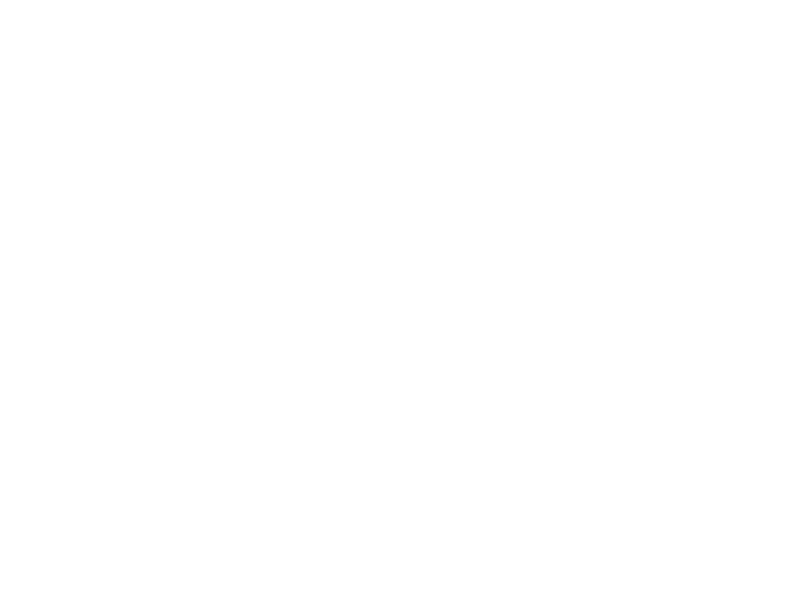

In [5]:
%matplotlib widget
figM = plt.figure(figsize=(8, 6))
gsM = gridspec.GridSpec(1, 1)
# axM = mapplot.mapPoint(figM, gsM[0, 0], lat, lon, tabSite['try_id'], extent=extentGlobal)


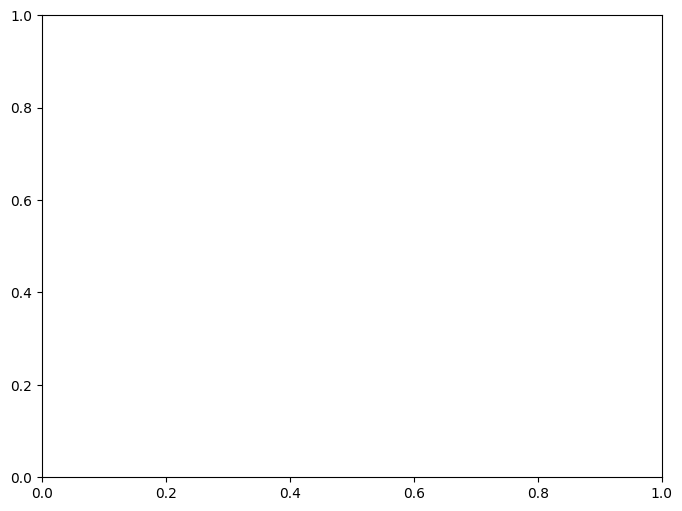

In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from hydroDL import utils
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0,0])
extent = [-125, -65, 25, 50]
# ax.set_extent(extent)
# ax.coastlines(resolution='auto', color='k')
# ax.set_extent(extent, crs=ccrs.PlateCarree())
# ax.coastlines(resolution='auto', color='k')